In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute

In [126]:
def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function


def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.
    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function


def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function


def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere.
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only.
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again.
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

In [162]:
# Make a quantum program for the n-bit Grover search.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.

# exactly_1_3_sat_formula = [[1, 2, 3]]
exactly_1_3_sat_formula = [[3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
QPS_SPECS = {
    'circuits': [{
        'name': 'grover',
        'quantum_registers': [
            {'name': 'f_in', 'size': n},
            {'name': 'f_out', 'size': 1},
            {'name': 'aux', 'size': len(exactly_1_3_sat_formula) + 1},
        ],
        'classical_registers': [
            {'name': 'ans', 'size': n},
        ]}]
}

qp = QuantumProgram(specs=QPS_SPECS)
qc = qp.get_circuit('grover')
f_in = qp.get_quantum_register('f_in')
f_out = qp.get_quantum_register('f_out')
aux = qp.get_quantum_register('aux')
ans = qp.get_classical_register('ans')

input_state(qc, f_in, f_out, n)
# Apply two full iterations.
black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
inversion_about_average(qc, f_in, n)
black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
inversion_about_average(qc, f_in, n)
black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
inversion_about_average(qc, f_in, n)
# Measure the output register in the computational basis.
for j in range(n):
    qc.measure(f_in[j], ans[j])
    
# circuit_drawer(qc)

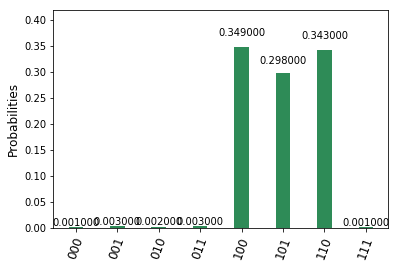

In [163]:
# Execute circuit.
result = qp.execute(['grover'], backend='local_qasm_simulator', coupling_map=None, shots=1000)
# Get counts and plot histogram.
counts = result.get_counts('grover')
plot_histogram(counts)

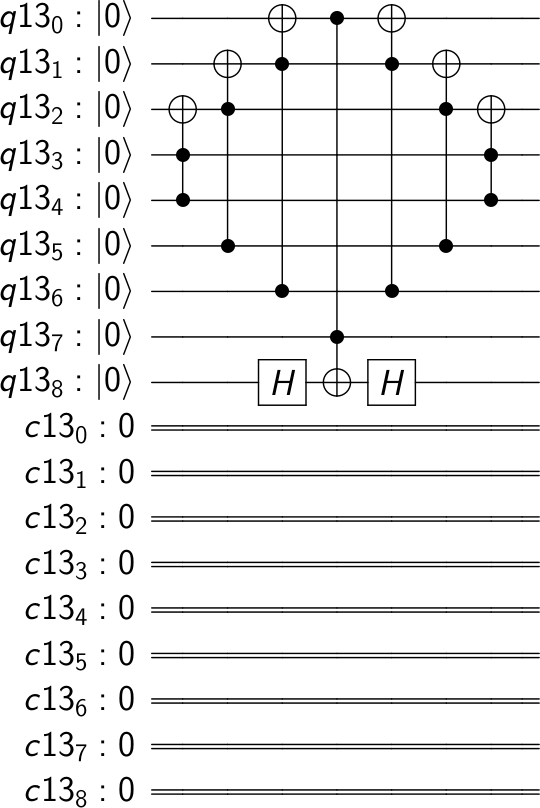

In [30]:
def left(circuit, qubits, n):
    for i in range(n - 2):
        circuit.ccx(qubits[i + n - 1], qubits[n - 2 - i], qubits[n - 3 - i])  # Last is target.
        
def right(circuit, qubits, n):
    for i in reversed(range(n - 2)):
        circuit.ccx(qubits[i + n - 1], qubits[n - 2 - i], qubits[n - 3 - i])  # Last is target.

q = QuantumRegister(9)
c = ClassicalRegister(9)
qc = QuantumCircuit(q, c)
left(qc, q, 5)
n_controlled_Z(qc, [q[0], q[7]], q[8])
right(qc, q, 5)
circuit_drawer(qc)

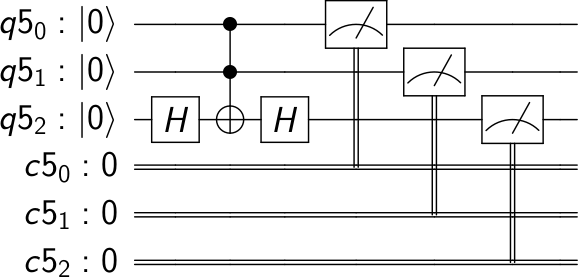

In [10]:
# desired_vector = []

q = QuantumRegister(3)
c = ClassicalRegister(3)

qc = QuantumCircuit(q, c)
# qc.cx(q[0], q[1])
# qc.cx(q[0], q[1])
n_controlled_Z(qc, [q[0], q[1]], q[2])

# qc.initialize(desired_vector, [q[0],q[1],q[2]])
qc.measure(q, c)
circuit_drawer(qc)

In [ ]:
backend = 'local_qasm_simulator'
plot_histogram(execute(qc, backend, shots=8192).result().get_data()['counts'])

In [61]:
import itertools

def get_all_states(n):
    all_states = np.array(list(map(np.array, itertools.product([0, 1], repeat=n))))
    return all_states

In [92]:
def sat(f, set_of_values):
    results = []
    for values in set_of_values:
        res = 1
        for clause in f:
            tmp = 0
            for literal in clause:
                if literal > 0:
                    tmp |= values[abs(literal) - 1]
                else:
                    tmp |= 1 - values[abs(literal) - 1]
            res *= tmp
        results.append(res)
    return results

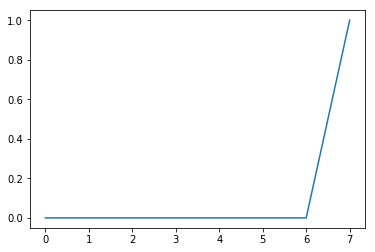

In [125]:
# exactly_1_3_sat_formula = [[1, -2, -3],
#                            [1, -2, 3],
#                            [1, 2, -3],
#                            [-1, -2, 3],
#                            [-1, 2, -3],
#                            [1, 2, 3],
#                            [1, -2, 3],
#                            [-1, -2, -3]]
# exactly_1_3_sat_formula = [[1, 2, 3], [1, -2, -3], [-1, 2, 3]]
exactly_1_3_sat_formula = [[1], [2], [3]]
res = sat(exactly_1_3_sat_formula, get_all_states(3))
plt.plot(res)